# Introduction

IID (Independent Identical Distribution) is a necessary condition for the application of many statistical
methods and thus if we are to use those methods as means for selecting machine learning models it is desirable
that whatever metric we are using to evaluate our model is IID.

That said, it is really hard to give any guarantees when talking about machine learning since models have so many parameters we can never really say that two different samples of metric from two models come from an identical distribution.

However, can we measure how similar two models are (and then, to some degree, how similar the metric distributions are too)? This is what we are trying to look into here

# The usual suspects

Lets just import all the libraries we are used too, we will be using the boston housing dataset for this experiment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
np.random.seed(123456)

In [2]:
boston = load_boston()
data = pd.DataFrame(boston['data'], columns=boston['feature_names'])
data.sample(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
387,22.59710,0.0,18.10,0.0,0.700,5.000,89.5,1.5184,24.0,666.0,20.2,396.90,31.99
296,0.05372,0.0,13.92,0.0,0.437,6.549,51.0,5.9604,4.0,289.0,16.0,392.85,7.39
481,5.70818,0.0,18.10,0.0,0.532,6.750,74.9,3.3317,24.0,666.0,20.2,393.07,7.74
456,4.66883,0.0,18.10,0.0,0.713,5.976,87.9,2.5806,24.0,666.0,20.2,10.48,19.01
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88


In [3]:
x = data
y = boston['target']

# What kind of sorcery is this?

A simple and intuitive way to define similarity is to think of how close two things are to a reference point, 
since "closeness" is a transitive property, that is: if A is close to C and B is close to C it is fair to say that A is close to B, we can try and compute how far our models are from a given point.

For our experiment we will be considering Linear Regression models, each model is uniquely defined by its coefficients and intercepts, as an array of numbers, those coefficients define a point in a n-dimensional space, we can then for a set of models (and a set of points) compute the average distance from the centroid, if a bunch of models is very similar, the average distance from the centroid will be smaller as the points that represent the coefficient vectors are clustered together.

As a safety measure we will normalize the distances to avoid the "curse of high dimensions"

In [4]:
# This function computes the scaled distances from the centroid for a set of points
def scaled_distances_from_centroid(points):
    scaled_coef = points/np.max(np.abs(coef))
    scaled_centroid = scaled_coef.mean(axis=0)
    return np.array([np.linalg.norm(point-scaled_centroid) for point in scaled_coef])

In [5]:
# Import our Model and Cross Validation utility
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
# Lets train 9 different sets, each one with increasingly more models
folds = np.arange(50, 500, 50)
# And store the avg of the (scaled) distances in an array
avg_scaled_distances = []
for f in folds:
    results = cross_validate(LinearRegression(normalize=True), x, y, cv = f, 
                             return_estimator= True, scoring="neg_root_mean_squared_error")
    coef = np.array([estimator.coef_ for estimator in results['estimator']])
    avg_scaled_distances.append(np.mean(scaled_distances_from_centroid(coef)))

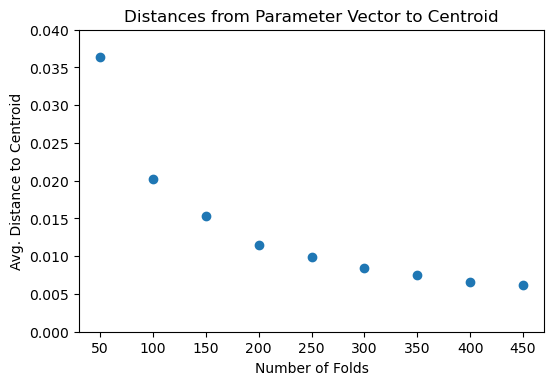

In [6]:
fig, ax = plt.subplots(dpi=100)
ax.set(title="Distances from Parameter Vector to Centroid",
      xlabel="Number of Folds",
      ylabel="Avg. Distance to Centroid")
ax.set_ylim(0, 0.04)
ax.scatter(folds, avg_scaled_distances);

# Interesting...

As we can see, for Linear Regression models as the number K of Folds increase, the average distance of each model from the "center" model decreases, we interpret this as the models becoming more and more similar the more in-sample data they have to learn from.

Lets try something else, lets try to see how the metric distribution from two different models trained on the same CV iteration compare.

In [7]:
# This function will sample the MSE for a model iteration number of times
def mean_squared_error_sample(model, x, true_y, samples=50, iterations=200):
    result = []
    for i in range(iterations):
        idx = np.random.choice(np.arange(len(x)), samples, replace=False)
        data = x.iloc[idx]
        values = true_y[idx]
        result.append(mean_squared_error(values, model.predict(data)))
        
    return np.array(result)

In [8]:
# First we split 30% of the data to use as Out-of-sample later
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.3)
# Cross validate a bunch of models
cv_results = cross_validate(LinearRegression(), x_train, y_train, cv = 250,
                            return_estimator=True, scoring='neg_root_mean_squared_error')
A, B = cv_results["estimator"][:2]
# We are using this metric
from sklearn.metrics import mean_squared_error
A_scores_250 = mean_squared_error_sample(A, x_val, y_val)
B_scores_250 = mean_squared_error_sample(B, x_val, y_val)

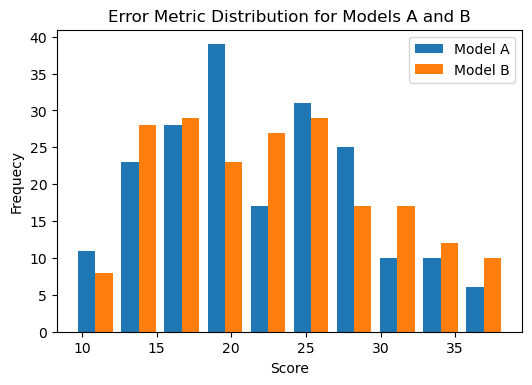

In [9]:
# Plot the histogram
fig, ax = plt.subplots(dpi=100)
ax.hist([A_scores_250, B_scores_250])
ax.set(title="Error Metric Distribution for Models A and B",
      xlabel="Score",
      ylabel="Frequecy")
ax.legend(["Model A", "Model B"]);

# Hmmm...

Ok, it is not perfect and we do have some outliers, but those distributions are damn close, given: we did use 250 folds in our cross validation, lets try with 3 of those to see what happens

In [10]:
# Cross validate 3 models
cv_results = cross_validate(LinearRegression(), x_train, y_train, cv = 3,
                            return_estimator=True, scoring='neg_root_mean_squared_error')
A, B, C = cv_results["estimator"][:3]

A_scores_3 = mean_squared_error_sample(A, x_val, y_val)
B_scores_3 = mean_squared_error_sample(B, x_val, y_val)
C_scores_3 = mean_squared_error_sample(C, x_val, y_val)

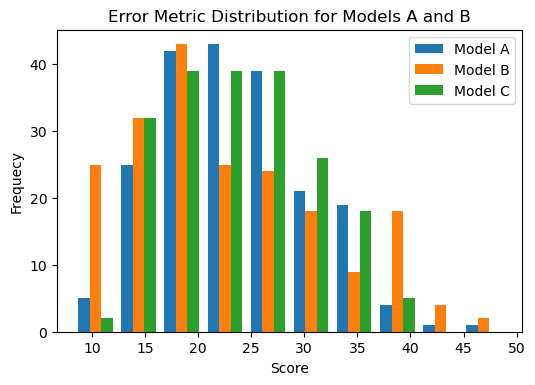

In [11]:
# Plot the histogram
fig, ax = plt.subplots(dpi=100)
ax.hist([A_scores_3, B_scores_3, C_scores_3])
ax.set(title="Error Metric Distribution for Models A and B",
      xlabel="Score",
      ylabel="Frequecy")
ax.legend(["Model A", "Model B", "Model C"]);

# Oh wow...

With only 3 folds the distributions look very different fro mone another, anyway, lets see what Mr. Kruskal and Mr. Wallis have to say about that

In [12]:
from scipy.stats import kruskal

t_3, p_3 = kruskal(A_scores_3, B_scores_3, C_scores_3)
t_250, p_250 = kruskal(A_scores_250, B_scores_250)
print(f"3-Fold T-statistic is {t_3:.4f} and p-value is {p_3:.4e}")
print(f"250-Fold T-statistic is {t_250:.4f} and p-value is {p_250:.4e}")

3-Fold T-statistic is 5.4286 and p-value is 6.6250e-02
250-Fold T-statistic is 0.5469 and p-value is 4.5959e-01


Ok, those p-values won't allow us to reject $H_0$, which should mean that, as far as the scores go, each of our models is sampling from distributions with the same median.

Note: since we are generating a lot of models (mostly for the 250 fold test, we must correct our p-value to account for multiple testing, a simples correction, called the Bonferroni correction, tells us to divide our significance level $\alpha$ by the number of tests we are performing, sure, we are only computing one of them, but given model A and 249 other models, at $\alpha=0.05$ whe can expect to see around $249*0.05 \tilde= 13$ false positives, applying the Bonferroni correction, and assuming we will test A against each other model, our $\alpha$ is then $0.05/249 = 0.0002$

That settles it for models that come from the same CV procedure, but what about models that are trained with a different number of folds?

In [13]:
# Here we do the same thing we did at the beggining 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
mse_means = np.array([])
mse_std = np.array([])
avg_scaled_distances = []
folds = np.arange(50, len(x_train), 50)
for f in folds:
    # Cross validate a bunch of models
    results = cross_validate(LinearRegression(normalize=True), x_train, y_train, cv = f, 
                             return_estimator= True, scoring="neg_root_mean_squared_error")
    coef = np.array([estimator.coef_ for estimator in results['estimator']])
    # Lets compute the "similarity" of our models
    avg_scaled_distances.append(np.mean(scaled_distances_from_centroid(coef)))
    
    # Lets also take a look at how our metric behaves as the number of folds increase, this will take time
    sampled_mse = np.array([mean_squared_error_sample(model, 
                                                      x_val, 
                                                      y_val, 
                                                      iterations=100) for model in results['estimator']])
    # Compute mean
    mse_means = np.append(mse_means, sampled_mse.mean())
    # And standard deviation
    mse_std = np.append(mse_std, sampled_mse.std())

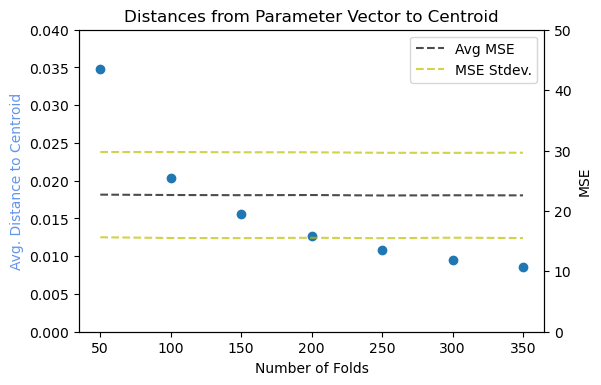

In [14]:
fig, ax = plt.subplots(dpi=100)
ax2 = ax.twinx()

ax.set(title="Distances from Parameter Vector to Centroid",
      xlabel="Number of Folds")
ax.set_ylabel("Avg. Distance to Centroid", color="cornflowerblue")
ax.set_ylim(0, 0.04)
ax.scatter(folds, avg_scaled_distances)

ax2.plot(folds, mse_means, 'k--', alpha=0.7, label="Avg MSE")
ax2.plot(folds, mse_means+mse_std, 'y--', alpha=0.7, label= "MSE Stdev.")
ax2.plot(folds, mse_means-mse_std, 'y--', alpha=0.7)
ax2.legend()
ax2.set_ylabel("MSE")
ax2.set_ylim(0, 50);

As we can see, even though our models get more and more similar the more folds we add to the cross validation, the MSE's Avg and Std Dev stay stable